<div class="alert alert-block alert-info">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center">Projet 07 : Implémentez un modèle de scoring</h1>


<div style="display: flex; margin: auto; padding: 10px 30px 30px 30px;">
    <h3 style="width: 100%; text-align: center; font-size:26px; float: left;" align="center">Parcours Data Science  - OpenClassrooms</h3> 

</div>
   
<div style="display: flex; padding: 10px 30px 30px 30px;">
    <h3 style="width: 100%; text-align: center; font-size:26px; float: left;" align="center">Feature importance _ Threshold </h3>
</div>
</div>

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', None)
import re
import time
import gc
import shap
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score, fbeta_score, precision_score, recall_score, make_scorer, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from lightgbm import LGBMClassifier
import pickle
%matplotlib inline

## Chargement des données : 

### Chargement du fichier et extraction X et y : 

In [6]:
# loading raw file
df_data = pd.read_csv('Home_credit_risk_data_modeling.csv', index_col=0)
df_data.info()
# getting only train data available with target
df_train_sample = df_data.loc[~(df_data['TARGET'].isnull())]
# define features and target
X = df_train_sample.drop(columns = ['TARGET','SK_ID_CURR']).copy()
y = df_train_sample['TARGET'].copy()
index_global_SK_ID_CURR = df_train_sample['SK_ID_CURR'].copy()
# Associate ID with index of our X data
X = X.set_index(index_global_SK_ID_CURR)
# getting rid of our initial df
del df_data, df_train_sample
gc.collect()
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356254
Columns: 797 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(622), int64(175)
memory usage: 2.1 GB
X shape: (307507, 795)
y shape: (307507,)


### Preprocessing 
Remplacer les valeurs infinies et imputer les valeurs manquantes : 

In [7]:
# Replace inf values by max() and min() values
col_min_max = {np.inf: X[np.isfinite(X)].max(),    # column-wise max
              -np.inf: X[np.isfinite(X)].min()}    # column-wise min

X = X.replace({col: col_min_max for col in X.columns})
# Checking that there is no infinite values anymore
np.isinf(X).values.sum()

0

In [11]:
# features detection before imputation, numerical continue or numerical discrete
def list_features_att(df):
    '''Function to attribute to columns of a dataframe a category into a several list
    it returns two lists.
    --> Numerical: num_list
    --> discrete_numerical: num_dis_list'''
    
    num_list = list()
    num_dis_list = list()
    for name in df.columns:
        if df[name].nunique() < 10:
            num_dis_list.append(name)
        else:
            num_list.append(name)
    return num_list, num_dis_list

In [12]:
# Imputation
numerical_cont_list, numerical_disc_list = list_features_att(X)
time_init = time.time()
#imputation on numeric continue columns with 'mean' strategy
X[numerical_cont_list] = SimpleImputer(strategy='mean').fit_transform(X[numerical_cont_list])
#imputation on  discrete numeric columns with 'most_frequent' strategy
X[numerical_disc_list] = SimpleImputer(strategy='most_frequent').fit_transform(X[numerical_disc_list])
print (f'time for imputation: {time.time() - time_init:.2f}')
#Checking all values have been imputed
X.isnull().sum().sum()

time for imputation: 8.59


0

### Split  X_train et  X_test et utilisation de  undersampling

In [13]:
time_init = time.time()
# Data split (with stratified mode)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=4)
# Getting index for later
index_train = X_train.index
index_test = X_test.index
# Normalization of the imput data
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)
undersampling = RandomUnderSampler(random_state = 4)
X_train_rus, y_train_rus = undersampling.fit_resample(X_train, y_train)
print (f'Time for Spliting, Normalize and Undersample: {time.time() - time_init:.2f}')

Time for Spliting, Normalize and Undersample: 7.51


## **Model optimization with custom metric**

In [17]:
lgbm_model = LGBMClassifier(n_estimators=60, max_depth=7, learning_rate=0.1, random_state=4)
time1 = time.time()
lgbm_model.fit(X_train_rus, y_train_rus)
time2 = time.time()
y_pred = lgbm_model.predict(X_test)
y_pred_prob = lgbm_model.predict_proba(X_test)[:,1]
print('model: LGBM classifier') 
print(f'Score AUC: {roc_auc_score(y_test, y_pred_prob):.4f}')
print(f'F1_score: {f1_score(y_test, y_pred):.4f}')
print(f'F2_score: {fbeta_score(y_test, y_pred, beta=2):.4f}')
print(f'Precision_score: {precision_score(y_test,y_pred):.4f}')
print(f'Recall_score: {recall_score(y_test, y_pred):.4f}')
print(f'Train Time(s): {time2 - time1:.3f}')

model: LGBM classifier
Score AUC: 0.7725
F1_score: 0.2790
F2_score: 0.4378
Precision_score: 0.1738
Recall_score: 0.7057
Train Time(s): 6.549


### Définition du Seuil : 
Lorsqu'on demande à notre modèle d'effectuer une prédiction sur l'un des clients,le modèle ne nous retourne pas une classe ou l'autre mais une probabilité.<br />
La modèle nous informe de la probabilité, pour un client donné, d'appartenir à l'une ou l'autre des deux classes (0 pour un client qui remboursera son prêt et qu'on nommera *Bon Client*, ou 1 pour un client qui ne remboursera pas son prêt (intégralement ou partiellement) et que l'on nommera *Mauvais Client*).

La question que l'on doit se poser est: <br />
*A partir de quel seuil de probabilité allons nous choisir de classer le client comme un client de confiance ou un client à risques?*

Pour réponse à cette question il faut bien comprendre ce que l'on cherche à faire ici.<br />
L'idée finale est de maximiser les gains financiers
de l'entreprise de prêts (et de minimiser ses pertes).<br />
L'entreprise réalise ses bénéfices avec les intêrets 
des prêts qu'elle octroie.<br />
Ne pas prêter d'argent à un client qui aurait remboursé 
son prêt est un manque à gagner pour l'entreprise.<br />
Cependant, lorsque l'entreprise prête à un client 
qui ne pourra pas rembourser son prêt, il s'agit 
d'une perte sèche.

On peut aisement comprendre qu'il y a un plus gros risque 
de prêter de l'argent à un client qui ne remboursera
pas son prêt, qu'il y a de gain à prêter à un 
client qui remboursera et payera ses intêrets.

Il nous faut donc déterminer le coût lorsque l'entreprise 
prête à un mauvais client comparé au coût de refuser
de prêter à un bon client.

<u>**FN**(Faux Bon Client)</u>:  Prêt à tort ===> Perte du capital ou partie du capital ===> Perte de beaucoup d'argent<br />
<u>**FP**(Faux Mauvais Client)</u>: Refus à tort de prêt ===> Perte de Marge, Manque à gagner

<u>Hypothèse</u>: Imaginons que nous ayons un capital valant **100**.
 - FN ---> Perte de 50% du capital prêté en moyenne ---> Perte de 50
 - FP ---> Manque à gagner de 1%/an sur en moyenne 10ans <br />(capital va de 100 à 0 soit moyenne de 50) ---> 10% de 50 ---> Perte de 5

<u>Rapport de coût entre FN et FP</u>:
- Les FN coûtent 10 fois plus chers que les FP.
- **1xFN = 10FP**

<u>Objectif:</u>:
 - Optimiser la Matrice de confusion en optimisant la somme de ces 2 coûts.
 - Résoudre: Min(10FN + FP)
 - Tester tous les seuils et calculer cette fonction
 
J'ai créé la fonction **findBestThreshold** qui automatise cette opération.
 
<u>Nous lui fournissons en paramètre</u>:
- **dictData** qui sont les données générées précédemment avec la fonction **bestAlgo**.
- **algo** qui est le nom de l'algorithme à utiliser, <br />
  ici **LGBMClassifier**(qui doit être présent dans dictData).
- **formula** qui est la formule à calculer et dont nous recherchons le minimum.
 

In [18]:
# create custom metrics
def custom_metrics_home_risk(y_true, y_pred):
    ''' Scoring function to minimise False Positive and False Negative for the classifier
    We want to reduce False Positive as possible but also and with a greater weight (X10) the False Negative
    y_true --> real value
    y_pred --> value estimated by a classifier
    sklearn.metrics.confusion_matrix must be imported to use it'''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    met = fp + (10 * fn)
    return met
# create custom scorer with sklearn to implement in sklearn GridSearchCV (don't forget greater_is_better = False, we want to minimize the score
custom_scorer_home_risk = make_scorer(custom_metrics_home_risk, greater_is_better=False)

Testons notre fonction métrique sur nos données : 

In [19]:
custom_metrics_home_risk(y_test, y_pred)

31262

### GridSearchCV avec une nouvelle métrique : 

In [20]:
# prameters dict
models_params = {'LGBM Classifier':{'model':LGBMClassifier(random_state=4),
                                       'params':{'n_estimators':range(55,65,1), 'max_depth':range(5,10,1), 'learning_rate':[0.1, 0.5]}}}
# grid search
scores_CV5 = list()
for model_name,mp in models_params.items():
    gride_mod = GridSearchCV(mp['model'],mp['params'], cv = 5, scoring=custom_scorer_home_risk, n_jobs=-1)
    gride_mod.fit(X_train_rus,y_train_rus)
    scores_CV5.append({'model':model_name, 'best_score custom':gride_mod.best_score_, 'best parameters':gride_mod.best_params_,
                       'Best model':gride_mod.best_estimator_,'Refit Time(s)':gride_mod.refit_time_, 'Comment':'train RUS data'})
# create df for gridsearch summary results   
df_scores_CV5 = pd.DataFrame(scores_CV5)
df_scores_CV5

,model,best_score custom,best parameters,Best model,Refit Time(s),Comment
0,LGBM Classifier,-12783.4,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...","LGBMClassifier(max_depth=7, n_estimators=62, r...",6.867751,train RUS data


In [21]:
print(f'Best paramater for our custom score: {gride_mod.best_params_}')

Best paramater for our custom score: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 62}


In [22]:
# evaluate the score on test data
lgbm_best_model = df_scores_CV5.loc[0, 'Best model']
time1 = time.time()
lgbm_best_model.fit(X_train_rus, y_train_rus)
time2 = time.time()
y_pred = lgbm_best_model.predict(X_test)
y_pred_prob = lgbm_best_model.predict_proba(X_test)[:,1]
print('model: LGBM classifier')
print(f'Custom Score: {custom_metrics_home_risk(y_test, y_pred)}')
print(f'Score AUC: {roc_auc_score(y_test, y_pred_prob):.4f}')
print(f'F1_score: {f1_score(y_test, y_pred):.4f}')
print(f'F2_score: {fbeta_score(y_test, y_pred, beta=2):.4f}')
print(f'Precision_score: {precision_score(y_test,y_pred):.4f}')
print(f'Recall_score: {recall_score(y_test, y_pred):.4f}')
print(f'Train Time(s): {time2 - time1:.3f}')

model: LGBM classifier
Custom Score: 31320
Score AUC: 0.7728
F1_score: 0.2786
F2_score: 0.4372
Precision_score: 0.1736
Recall_score: 0.7045
Train Time(s): 6.706


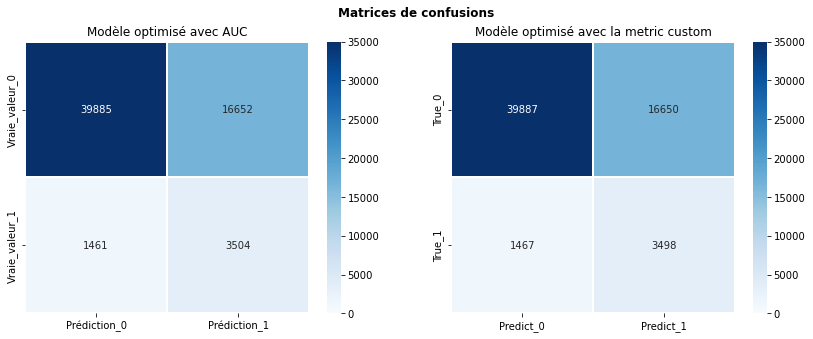

In [24]:
# Confusion matrix comparison before/after optimization
figure_cm = plt.figure(figsize=(14,5))
plt.title('Matrices de confusions', fontweight = 'bold', pad=25)
plt.axis('off')
# Confusion matrix with initial model and treshold at 0.5
figure_cm.add_subplot(1,2,1)
plt.title('Modèle optimisé avec AUC')
cm0 = confusion_matrix(y_test, lgbm_model.predict(X_test))
df_cm0 = pd.DataFrame(cm0, index = ['Vraie_valeur_0', 'Vraie_valeur_1'], columns=['Prédiction_0', 'Prédiction_1'])
sns.heatmap(df_cm0, fmt='g',cmap='Blues', annot=True, vmin=0, vmax=35000, linewidths= 0.3)
# Confusion matrix with optimised model with custom metric
figure_cm.add_subplot(1,2,2)
plt.title('Modèle optimisé avec la metric custom')
cm = confusion_matrix(y_test, lgbm_best_model.predict(X_test))
df_cm = pd.DataFrame(cm, index = ['True_0', 'True_1'], columns=['Predict_0', 'Predict_1'])
sns.heatmap(df_cm, fmt='g', cmap='Blues', annot=True, vmin=0, vmax=35000, linewidths= 0.3)
#plt.savefig('Confusion_matrix_avant_après_GridSearchCV_custom_score.jpg', dpi=300, bbox_inches='tight')
plt.show()

## Optimisation du seuil de décision (0,5 dans le modèle) avec notre métrique métier et le meilleur modèle(LGBM Classifier) : 


In [25]:
# Function to apply a new treshold
def Treshold_applied(y_prob_pos, treshold):
    '''Function to applied a new treshold for positive value for our binary classifier
    y_prob_pos --> postive probability (rejected loan) return by our classifier on our data must be 1-D
    treshold --> treshold to applied on our classifier probability and return estimated label with it'''
    return (y_prob_pos >= treshold).astype('int')

# Evaluate best treshold with our custom metrics
tresh = np.arange(0,1, 0.001)
scores = [custom_metrics_home_risk(y_test, Treshold_applied(lgbm_best_model.predict_proba(X_test)[:,1], t)) for t in tresh]
# lower the value better the result, we use argmin (change this step if our metric must be greater the better)
best_ix = np.argmin(scores)
print(f'Treshold:{tresh[best_ix]} \nBest custom score: {scores[best_ix]} \
      \nScore AUC:{roc_auc_score(y_test, Treshold_applied(lgbm_best_model.predict_proba(X_test)[:,1], tresh[best_ix]))}')

Treshold:0.49 
Best custom score: 31240       
Score AUC:0.7067060398611423


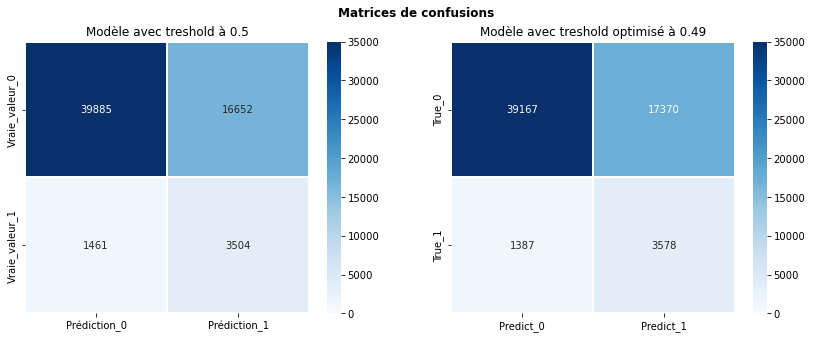

In [26]:
# Confusion matrix comparison before/after treshold optimization
treshold = 0.49
figure_cm = plt.figure(figsize=(14,5))
plt.title('Matrices de confusions', fontweight = 'bold', pad=25)
plt.axis('off')
# Confusion matrix with initial model and treshold at 0.5
figure_cm.add_subplot(1,2,1)
plt.title('Modèle avec treshold à 0.5')
cm0 = confusion_matrix(y_test, lgbm_model.predict(X_test))
df_cm0 = pd.DataFrame(cm0, index = ['Vraie_valeur_0', 'Vraie_valeur_1'], columns=['Prédiction_0', 'Prédiction_1'])
sns.heatmap(df_cm0, fmt='g',cmap='Blues', annot=True, vmin=0, vmax=35000, linewidths= 0.3)
# Confusion matrix treshold changed
figure_cm.add_subplot(1,2,2)
plt.title('Modèle avec treshold optimisé à 0.49')
cm = confusion_matrix(y_test, Treshold_applied(lgbm_best_model.predict_proba(X_test)[:,1], treshold))
df_cm = pd.DataFrame(cm, index = ['True_0', 'True_1'], columns=['Predict_0', 'Predict_1'])
sns.heatmap(df_cm, fmt='g', cmap='Blues', annot=True, vmin=0, vmax=35000, linewidths= 0.3)
#plt.savefig('Confusion_matrix_avant_après_treshold_opti.jpg', dpi=300, bbox_inches='tight')
plt.show()

--> Le seuil fixé à 0.49 attrape un peu de FP mais par contre on perd du vrai positif en faux positif..

- Maintenant, nous allons sauvegarder notre meilleur modèle avec pickle et exporter un échantillon de données de test pour l'utilisation de l'API :

In [27]:
# export a sample of our test data for API purpose (also dashboard)
# we can't have to big file because on Heroku we have a limitation on file size
# add predict proba to our data

test_sample_data = pd.DataFrame(X_test, columns=X.columns, index= index_test)
test_sample_data

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
345593         0.720156     -0.717411        -0.665847     -0.577413   
402371         0.720156     -0.717411        -0.665847     -0.577413   
262097         0.720156     -0.717411        -0.665847     -0.577413   
100435         0.720156     -0.717411        -0.665847     -0.577413   
239891         0.720156     -0.717411        -0.665847     -0.577413   
...                 ...           ...              ...           ...   
304484        -1.388588      1.393901        -0.665847     -0.577413   
348857        -1.388588     -0.717411        -0.665847     -0.577413   
114730        -1.388588     -0.717411        -0.665847      0.808244   
427417        -1.388588      1.393901        -0.665847     -0.577413   
443947        -1.388588     -0.717411        -0.665847     -0.577413   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
345593              0.497709    1.304607     0.407461         1.586177   
402371             -0.358448   -1.042371    -0.881978        -0.971572   
262097              0.567599    2.792815     1.617047         2.195165   
100435             -0.218667   -0.371806    -0.747752        -0.240786   
239891             -0.271085   -1.098251    -0.804612        -1.032470   
...                      ...         ...          ...              ...   
304484              0.043421    2.374259     2.569057         2.304783   
348857             -0.043941   -0.818849    -0.430208        -0.727977   
114730              0.043421    0.745803     2.782513         0.977189   
427417              0.654962   -0.785522    -0.749616        -0.825415   
443947             -0.218667   -0.930610    -0.733459        -0.849774   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
345593                       -0.662420   -1.775690       0.000441   
402371                       -0.775054   -0.987882       0.000441   
262097                       -1.053164   -0.231695       0.472116   
100435                        1.081304   -0.096269      -1.088109   
239891                        0.847422   -1.718862       0.000441   
...                                ...         ...            ...   
304484                        0.847422   -0.590769      -0.439471   
348857                        0.565259    1.172978       0.314913   
114730                        0.565259   -0.023859       0.945613   
427417                        0.565259    0.354235       0.103421   
443947                       -0.191472    1.356754       0.375340   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
345593              -0.553659        -0.692531     0.000691    0.002016   
402371              -1.378875        -0.571192     0.000691    0.002016   
262097              -0.488152         1.674573     0.000691    0.002016   
100435               0.482541         1.975600     0.000691    0.002016   
239891               1.412114        -1.258779     0.000691    0.002016   
...                       ...              ...          ...         ...   
304484              -0.748478         0.894821    -0.727848    0.002016   
348857               0.075321        -0.313264     0.000691    0.002016   
114730               0.711389        -0.126945     0.000691    0.002016   
427417              -0.418958        -0.974329    -1.303641    0.002016   
443947               0.286304         0.538098     0.000691    0.002016   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
345593           -2.131437        -0.498113          0.043658   -0.625330   
402371 

In [28]:
test_sample_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61502 entries, 345593 to 443947
Columns: 795 entries, CODE_GENDER to CC_COUNT
dtypes: float64(795)
memory usage: 373.5 MB


## Utilisation de SHAP (SHapely Additive exPlanations) :
**Pour obtenir l'importance des features globales et locales**
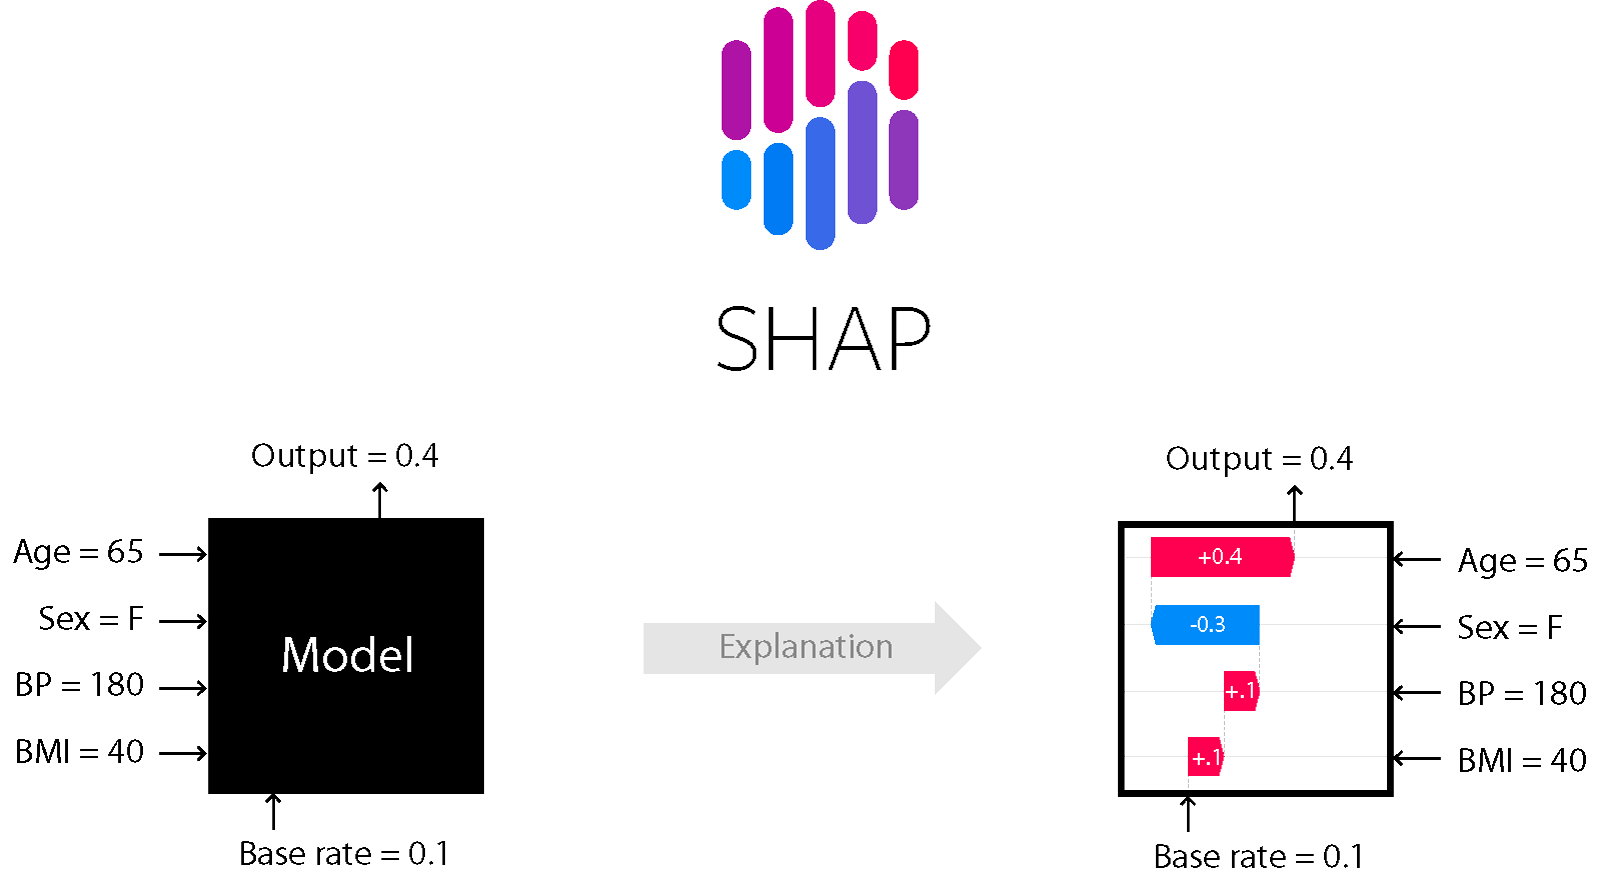

source : https://shap.readthedocs.io/en/latest/index.html

In [29]:
help(shap.TreeExplainer)

Help on class Tree in module shap.explainers._tree:

class Tree(shap.explainers._explainer.Explainer)
 |  Tree(model, data=None, model_output='raw', feature_perturbation='interventional', feature_names=None, approximate=False, **deprecated_options)
 |  
 |  Uses Tree SHAP algorithms to explain the output of ensemble tree models.
 |  
 |  Tree SHAP is a fast and exact method to estimate SHAP values for tree models and ensembles of trees,
 |  under several different possible assumptions about feature dependence. It depends on fast C++
 |  implementations either inside an externel model package or in the local compiled C extention.
 |  
 |  Method resolution order:
 |      Tree
 |      shap.explainers._explainer.Explainer
 |      shap._serializable.Serializable
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, X, y=None, interactions=False, check_additivity=True)
 |      Explains the output of model(*args), where args is a list of parallel iteratable datasets.

Les modèles de Machine Learning peuvent être décrites comme des sortes de boîtes noires.<br />
Des décisions sont prises sans que l'on puisse savoir exactement sur quels critères et celà peut être source d'incompréhension ou même de frustration ou d'injustice dans le cas d'un refus d'optention de prêt.

Pour remédier à celà, nous allons utiliser la bibliothèque **SHAP**.<br />
Grace à elle nous allons être capables d'expliquer les choix de notre modèle de Machine Learning.

Non seulement nous saurons quelles sont les features qui ont le plus contribuées à la prise de décision mais nous saurons également si elles ont pesé d'une manière positive ou négative dans la décision finale.

Dans notre cas celà est très important afin de fournir un maximum de transparence au client.

La bibliothèque **SHAP** ne donne pas accès par défaut au tableau de données permettant d'afficher les graphiques des features importance locales et globales.<br />
Elle fournit à la place des méthodes permettant de générer directement des graphiques.<br />
Les graphiques fournis sont assez austères à mon gout et surtout, ils ne sont pas intéractifs.

J'ai créé une fonction me permettant de générer les données au format *dataframe pandas* pour ensuite les afficher avec la bibliothèque **plotly**.<br />
Il suffit de survoler les graphiques du dashboard pour obtenir des informations complémentaires.



### Globales :

Ce graphique affiche les features qui, d'une manière générale, ciontribuent le plus dans l'attribution d'un prêt.<br />
Ce graphique ainsi que le suivant sont les moins intuitifs,et pour être bien appréhendé par le client,l'aide de l'opérateur sera nécessaire.

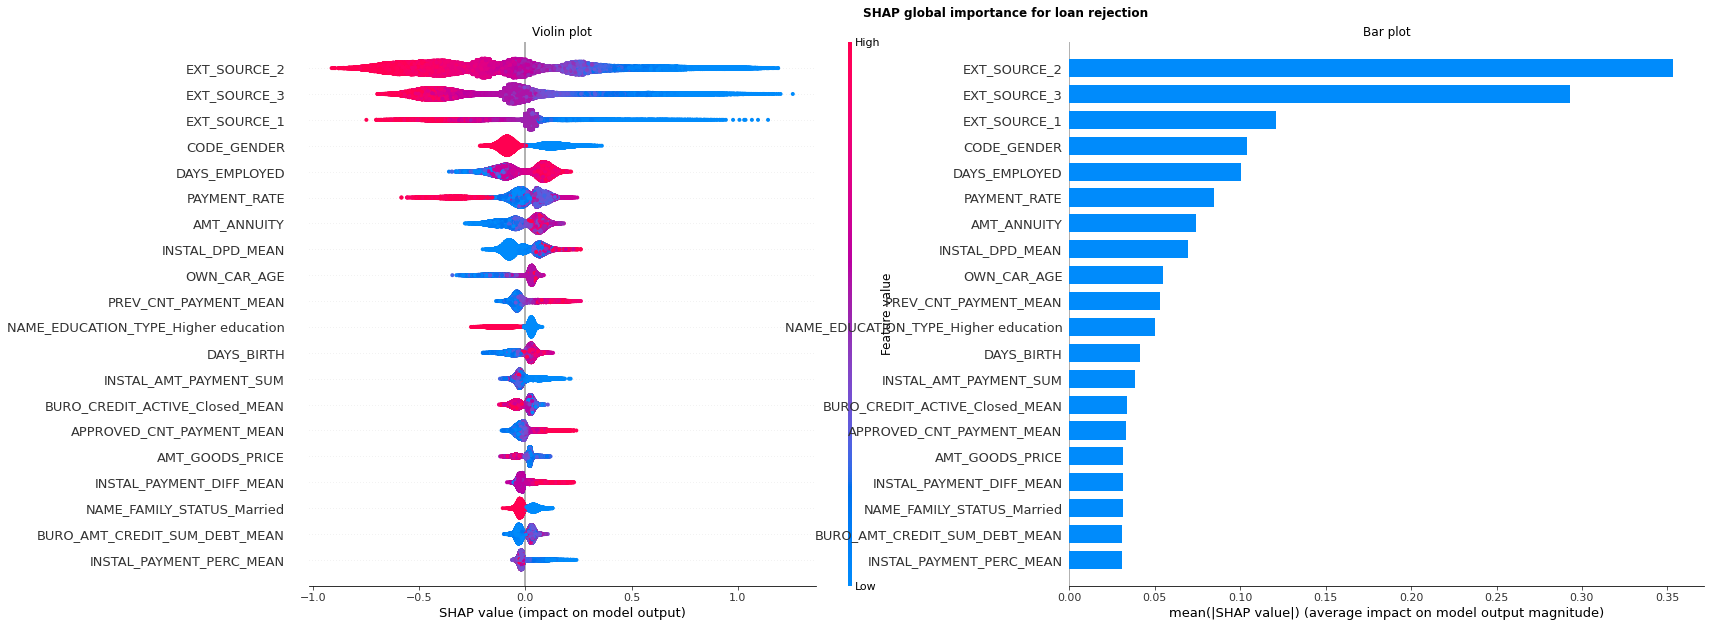

In [62]:
# using tree explainer with LGBM classifier
explainer =  shap.Explainer(lgbm_best_model)
shap_values =explainer.shap_values(X_test)
# ploting SHAP features importances, we focuse on the probability to have the loan rejected
figure_shap_1 = plt.figure(figsize=(25,10))
plt.title('SHAP global importance for loan rejection', fontweight='bold', pad=25)
plt.axis('off')
figure_shap_1.add_subplot(1,2,1)
plt.title('Violin plot')
shap.summary_plot(shap_values[1], X_test, feature_names=X.columns, show=False, plot_size=None)
figure_shap_1.add_subplot(1,2,2)
plt.title('Bar plot')
shap.summary_plot(shap_values[1], X_test, feature_names=X.columns, plot_type='bar', show=False, plot_size=None)
plt.show()

### locales (Force_plot and waterfall ):
Il s'agit d'un graphique très important puisqu'il indique au client les caractéristiques qui ont le plus contribué (positivement ou négativement) à l'attribution ou non de son prêt.

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.


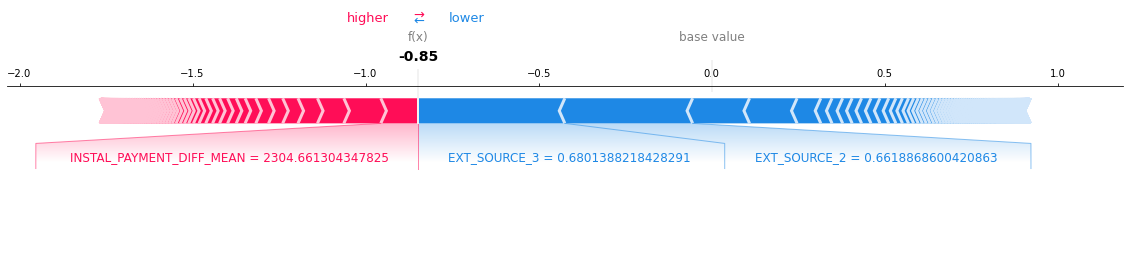

In [32]:
# Force plot
choosen_client = X_test[3,:]
shap_values = explainer.shap_values(choosen_client.reshape(1, -1))
# using invert transform of the std_scaler to get real values of data into our force plot
choosen_client = std_scaler.inverse_transform(choosen_client.reshape(1, -1))
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_client, feature_names=X.columns, matplotlib=True)

In [34]:
# Waterfallplot
# let's try defining a class shap object to create waterfall plot
class ShapObject:
    
    def __init__(self, base_values, data, values, feature_names):
        self.base_values = base_values # Single value
        self.data = data # Raw feature values for 1 row of data
        self.values = values # SHAP values for the same row of data
        self.feature_names = feature_names # Column names

shap.waterfall_plot(lin_reg_explainer2.expected_value,
                    lin_reg_explainer2.shap_values(X_test[0].reshape(1,-1))[0],
                    feature_names=boston.feature_names,
                    max_display=len(boston.feature_names))

In [55]:
# https://coderzcolumn.com/tutorials/machine-learning/shap-explain-machine-learning-model-predictions-using-game-theoretic-approach
shap_object = ShapObject(base_values = explainer.expected_value[1],
                         values = explainer.shap_values(X_test)[1][5,:].reshape(1, -1),
                         feature_names = X.columns,
                         data = std_scaler.inverse_transform(test_sample_data.iloc[5,:].values.reshape(1, -1)))

figure_waterfall = plt.figure(figsize=(7,7), facecolor='w')
plt.title('Waterfall plot for passenger 40', fontweight='bold')

shap.waterfall_plot(shap_object, max_display=len(X.columns), show=True)

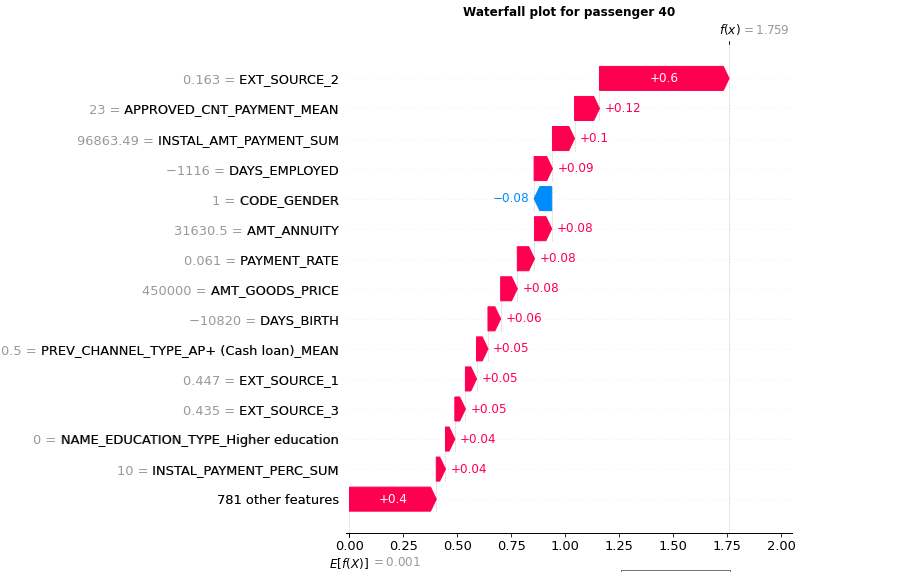

In [47]:
gc.collect()

49208